In [11]:
# This code demonstrates a Graph Convolution Network.

## A random graph is initialized and an optimum separation into two groups is achieved,
## using two initial labeled nodes

# The following resources were helpful in the making
# 1) Tobias Skovgaard Jepsen article on Graph Convolution Network
# 2) Semi-Supervised Classification with Graph Convolutional Networks
#    - Thomas N. Kipf, Max Welling
# 3) missinglink.ai
# 4) Pytorch documentation


In [12]:
%matplotlib inline

In [13]:
import torch
import numpy as np

dtype = torch.float
device = torch.device("cpu")


# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 32, 34, 4, 2 

D_in = N # Identity feature matrix


# Creating a random graph defined by the adjacency matrix
torch.manual_seed(5)

A_ = torch.randint(low=0, high=2, size=(N, N), device=device, dtype=dtype)

I = torch.eye(N, device=device, dtype=dtype)
I_ = 1 - I

A = np.multiply(A_,I_) + I

D_ = torch.sum(A, dim=1)
D_ = torch.diag(D_)
D = torch.inverse(D_)

# Create Tensors to hold input and outputs.

# Identity feature matrix
x = torch.eye(D_in, device=device, dtype=dtype)

# Labelling 'node 0' and 'node N-1' for training
y = torch.zeros(N, D_out, device=device, dtype=dtype)

y[0] = torch.tensor([1, 0])
y[N-1] = torch.tensor([0, 1])


# Creating random Tensors for initial weights.
w1 = torch.randn(D_in, H, device=device, dtype=dtype, requires_grad=True)
w2 = torch.randn(H, D_out, device=device, dtype=dtype, requires_grad=True)



learning_rate = 1e-2
for t in range(5000):
    # Forward propagation
    
    h_0 = x
    z_1 = ((D.mm(A)).mm(h_0)).mm(w1)
    h_1 = z_1.clamp(min=0)
    z_2 = ((D.mm(A)).mm(h_1)).mm(w2)
    
    y_pred = z_2
    
    # Loss function over the known two labels of node 1 and node N-1
    loss = (y_pred[0] - y[0]).pow(2).sum() + (y_pred[N-1] - y[N-1]).pow(2).sum()
    
    if t % 1000 == 999:
        print("Cost at ", t, " = ", loss.item())

    # Using autograd to compute the backward pass.
    loss.backward()

    # Updating the weights with gradient descent
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad

        # Manually zero the gradients after updating weights
        w1.grad.zero_()
        w2.grad.zero_()

Cost at  999  =  0.6714320778846741
Cost at  1999  =  0.3715211749076843
Cost at  2999  =  0.14226481318473816
Cost at  3999  =  0.037847455590963364
Cost at  4999  =  0.008435971103608608


In [14]:
print(y_pred)

tensor([[ 0.9421,  0.0220],
        [ 0.5686,  0.4946],
        [ 0.6040,  0.4185],
        [ 0.6661,  0.3948],
        [ 0.9110, -0.0594],
        [ 0.2710,  0.8684],
        [ 0.6540,  0.3533],
        [ 0.3961,  0.5861],
        [ 0.3413,  0.5891],
        [ 0.7338,  0.2673],
        [ 0.3627,  0.6216],
        [ 0.6717,  0.2306],
        [ 0.1983,  0.8701],
        [ 0.6754,  0.2332],
        [ 0.5179,  0.5198],
        [ 0.8315,  0.2714],
        [ 0.7587,  0.2168],
        [ 0.6816,  0.1982],
        [ 0.5305,  0.3643],
        [ 0.8392,  0.1646],
        [ 0.5494,  0.4358],
        [ 0.0156,  1.0571],
        [ 0.8955, -0.0562],
        [ 0.7250,  0.3126],
        [ 0.6249,  0.4437],
        [ 0.4457,  0.6327],
        [ 0.7299,  0.3263],
        [ 0.4879,  0.5586],
        [ 0.8392,  0.0766],
        [ 0.5412,  0.3670],
        [ 0.6808,  0.3109],
        [ 0.0648,  0.9798]], grad_fn=<MmBackward>)


In [15]:
u = np.zeros((N,2), dtype=float)
for i in range(0, N):
    if(y_pred[i][0] < y_pred[i][1]):
        u[i][1] = 1
    else:
        u[i][0] = 1
print(u)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [16]:
import matplotlib.pyplot as plt

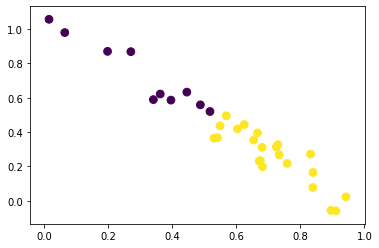

In [17]:
# Detaching the Gradient Tensor and Converting the pytorch tensor into a numpy array
w = y_pred.detach().numpy()

# Scatter plot
plt.scatter(w[:, 0], w[:, 1], c = u.T[0], marker='o', s=60)
plt.show()

In [55]:
# It can be observed that an optimum separation of the graph nodes into two groups
# has been achieved, using only two initial labeled data points.

In [56]:
##################################################################################

In [57]:
### Since graph separation has been achieved. We now apply the above implementation to the famous 
### Zachary Karate Club (ZKC) dataset.

## 'zkc.txt' stores the adjecancy matrix for the netowrk of karate clubs
#   character '1' at location (i,j) refers to an edge from node i to node j

## 'y_val.TXT' stores the true or actual labels of the nodes
#   Label '1' means that the node groups with the 'Administrator'
#   Label '0' means that the node groups with the 'Instructor'

## we use 'node 0' and 'node N-1' as our training label and try to predict 
#  the groups of the other nodes using the information in the adjacency/connectivity matrix

In [58]:
N, D_in, H, D_out = 34, 34, 4, 2

torch.manual_seed(5)

# Converting the ZKC adjecancy matrix into a pytorch tensor

mat = open('zkc.txt').read()
mat = [item.split() for item in mat.split('\n')[:-1]]
mat = np.array(mat)
nat = np.zeros(mat.shape)
for i in range(0,N):
    for j in range(0,N):
        if(mat[i][j] == '1'):
            nat[i][j] = 1

A_ = torch.tensor(nat, device=device, dtype=dtype)

I = torch.eye(N, device=device, dtype=dtype)
I_ = 1 - I

A = np.multiply(A_,I_) + I

D_ = torch.sum(A, dim=1)
D_ = torch.diag(D_)
D = torch.inverse(D_)

# Create Tensors to hold input and outputs.

# Identity feature matrix
x = torch.eye(D_in, device=device, dtype=dtype)

# Labelling 'node 0' and 'node N-1' for training
y = torch.zeros(N, D_out, device=device, dtype=dtype)

y[0] = torch.tensor([1, 0])
y[N-1] = torch.tensor([0, 1])


# Creating random Tensors for initial weights.

w1 = torch.randn(D_in, H, device=device, dtype=dtype, requires_grad=True)
w2 = torch.randn(H, D_out, device=device, dtype=dtype, requires_grad=True)

learning_rate = 1e-3
for t in range(5000):
    # Forward propagation
    
    h_0 = x
    z_1 = ((D.mm(A)).mm(h_0)).mm(w1)
    h_1 = z_1.clamp(min=0)
    z_2 = ((D.mm(A)).mm(h_1)).mm(w2)
    
    y_pred = z_2
    
    # Loss Function
    loss = (y_pred[0] - y[0]).pow(2).sum() + (y_pred[N-1] - y[N-1]).pow(2).sum()
    
    if t % 1000 == 999:
        print(t, loss.item())

    # Use autograd to compute the backward propagation
    loss.backward()

    # Updating weights
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad

        # Manually zero the gradients after updating weights
        w1.grad.zero_()
        w2.grad.zero_()

999 0.5178006291389465
1999 0.11166773736476898
2999 0.021549202501773834
3999 0.004101418890058994
4999 0.0008291585836559534


In [59]:
print(y_pred)

tensor([[ 9.9007e-01,  2.1034e-02],
        [ 7.2926e-01, -3.9546e-03],
        [ 4.7358e-01,  2.6195e-01],
        [ 7.9743e-01, -1.4893e-01],
        [ 1.4920e+00,  3.9692e-04],
        [ 1.1263e+00,  2.1986e-01],
        [ 1.2283e+00,  2.4396e-01],
        [ 6.3553e-01, -1.4890e-01],
        [ 6.1720e-03,  4.2084e-01],
        [ 1.3164e-01,  6.0731e-01],
        [ 1.4103e+00,  4.0240e-02],
        [ 6.8554e-01,  6.8613e-02],
        [ 8.8088e-01, -1.4743e-01],
        [ 4.3874e-01,  1.1149e-01],
        [-6.7824e-01,  1.4890e+00],
        [-6.9973e-01,  1.1954e+00],
        [ 1.1607e+00,  3.9944e-01],
        [ 8.1194e-01, -9.5273e-02],
        [-6.3050e-01,  9.4108e-01],
        [ 2.5228e-01,  4.7194e-01],
        [-5.7040e-01,  1.1132e+00],
        [ 5.8405e-01, -1.1371e-01],
        [-5.4956e-01,  1.1956e+00],
        [-3.2141e-01,  9.3720e-01],
        [-5.6030e-01,  9.3425e-01],
        [-4.4239e-01,  7.9932e-01],
        [ 1.7889e-01,  1.2674e+00],
        [-2.7772e-01,  7.060

In [60]:
## Predicted groups for each nodes
#  [1. 0.] refers to the 'Administrator Group'
#  [0. 1.] refers to the 'Instructor Group'

u = np.zeros((N,2), dtype=float)
for i in range(0, N):
    if(y_pred[i][0] < y_pred[i][1]):
        u[i][1] = 1
    else:
        u[i][0] = 1

print("u =\n", u)

u =
 [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [61]:
# Detaching the Gradient Tensor and Converting the pytorch tensor into a numpy array
w = y_pred.detach().numpy()

Predicted groups:


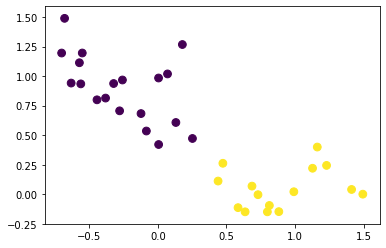

Yellow: Administrator
Violet: Instructor


In [62]:
# Displaying the predicted groups on a scatter plot

print("Predicted groups:")

plt.scatter(w[:, 0], w[:, 1], c = u.T[0], marker='o', s=60)
plt.show()

print("Yellow: Administrator")
print("Violet: Instructor")

Actual groups:


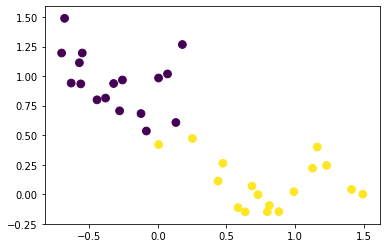

Yellow: Administrator
Violet: Instructor


In [63]:
# Displaying the actual groups on a scatter plot

mat = open('y_val.txt').read()
mat = [item.split() for item in mat.split('\n')[:-1]]
mat = np.array(mat).reshape(N,1)

ynat = np.zeros(mat.shape)
for i in range(0,N):
    if(mat[i] == '1'):
        ynat[i] = 1

print("Actual groups:")
        
plt.scatter(w[:, 0], w[:, 1], c = ynat.T[0], marker='o', s=60)
plt.show()

print("Yellow: Administrator")
print("Violet: Instructor")

Incorrectly predicted nodes are:
8
19


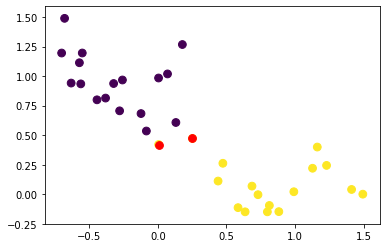

Yellow: Administrator
Violet: Instructor
Red: 'Instructor' nodes incorrectly predicted as 'Administrator'


In [64]:
## The mismatched groups are marked in red
#  'Node 8' and 'Node 19' are incorrectly predicted in the 'Administrator Group',
#  whereas they belong to the 'Instructor Group'

plt.scatter(w[:, 0], w[:, 1], c = ynat.T[0], marker='o', s=60)

print("Incorrectly predicted nodes are:")
for i in range(0,N):
    if(err[i] == 1):
        print(i)
        plt.scatter(w[i, 0], w[i, 1], c='r', marker='o', s=60)

plt.show()

print("Yellow: Administrator")
print("Violet: Instructor")
print("Red: 'Instructor' nodes incorrectly predicted as 'Administrator'")

In [65]:
y_test = ynat.T[0]
y_train = u.T[0]

err = np.abs(y_test - y_train)
s = np.sum(err)

acc = s/N
print("Accuracy of prediction = ", acc*100, "%")

Accuracy of prediction =  5.88235294117647 %
